In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv
/kaggle/input/lstm-for-household-electric-power-consumption/__results__.html
/kaggle/input/lstm-for-household-electric-power-consumption/__resultx__.html
/kaggle/input/lstm-for-household-electric-power-consumpt

# ⚡ Smart City Energy Forecasting using LightGBM

> **Summary:**  
This project forecasts hourly electricity usage in a smart city using timestamp-based features. With Japan's goals toward carbon neutrality and smart infrastructure, energy optimization through AI helps reduce waste and ensure sustainable urban living.

🏷️ Tags: #Japan #SmartCity #Sustainability #StudentProject #EnergyAI


### 🌆 Smart City Energy Demand Forecasting with LightGBM

In this project, I built a light regression model to forecast hourly electricity consumption using the PJM dataset.

This project aligns with Japan’s **Smart City and Sustainable Energy goals**, especially in the context of optimizing demand-side energy management.

It complements my previous work on:
- 🌊 Tsunami Disaster Prediction (DisasterAI)
- 📈 Click-Through Rate (CTR) Prediction (Digital Economy)

By demonstrating versatility in machine learning applications, this portfolio reflects my readiness to contribute to Japan’s innovation-driven future.

🇯🇵 Built as part of my METI Internship application.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [3]:
import os

# List all dataset folders
print("📂 Folders in /kaggle/input:")
input_folders = os.listdir("/kaggle/input")
print(input_folders)

# List files in each folder
for folder in input_folders:
    print(f"\n📁 Files in {folder}:")
    files = os.listdir(f"/kaggle/input/{folder}")
    print(files)


📂 Folders in /kaggle/input:
['hourly-energy-consumption', 'lstm-for-household-electric-power-consumption']

📁 Files in hourly-energy-consumption:
['est_hourly.paruqet', 'DOM_hourly.csv', 'EKPC_hourly.csv', 'DUQ_hourly.csv', 'DAYTON_hourly.csv', 'PJME_hourly.csv', 'PJM_Load_hourly.csv', 'NI_hourly.csv', 'FE_hourly.csv', 'COMED_hourly.csv', 'AEP_hourly.csv', 'pjm_hourly_est.csv', 'DEOK_hourly.csv', 'PJMW_hourly.csv']

📁 Files in lstm-for-household-electric-power-consumption:
['__results__.html', '__resultx__.html', '__notebook__.ipynb', '__results___files', '__output__.json', 'custom.css']


In [4]:
import os

# List files inside the real dataset folder
files = os.listdir("/kaggle/input/hourly-energy-consumption")
print(files)


['est_hourly.paruqet', 'DOM_hourly.csv', 'EKPC_hourly.csv', 'DUQ_hourly.csv', 'DAYTON_hourly.csv', 'PJME_hourly.csv', 'PJM_Load_hourly.csv', 'NI_hourly.csv', 'FE_hourly.csv', 'COMED_hourly.csv', 'AEP_hourly.csv', 'pjm_hourly_est.csv', 'DEOK_hourly.csv', 'PJMW_hourly.csv']


In [5]:
import pandas as pd

# Load PJM Hourly Load dataset
df = pd.read_csv("/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv")

# Preview data
df.head()


,Datetime,PJM_Load_MW
0,1998-12-31 01:00:00,29309.0
1,1998-12-31 02:00:00,28236.0
2,1998-12-31 03:00:00,27692.0
3,1998-12-31 04:00:00,27596.0
4,1998-12-31 05:00:00,27888.0


In [6]:
print(df.columns)


Index(['Datetime', 'PJM_Load_MW'], dtype='object')


In [7]:
y = df['PJM_Load_MW']
X = df.drop(columns=['PJM_Load_MW'])


In [8]:
# Load CSV again (clean slate)
df = pd.read_csv("/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv")

# Convert Datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

# Clean column names
df.columns = df.columns.str.strip()

# ⛔ Drop all rows with ANY NaNs
df = df.dropna()

# Feature Engineering
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

# Define X and y
y = df['PJM_Load_MW']
X = df.drop(columns=['PJM_Load_MW'])



In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score

model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R² Score: {r2:.2f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44
[LightGBM] [Info] Number of data points in the train set: 26316, number of used features: 3
[LightGBM] [Info] Start training from score 29766.012920
✅ RMSE: 2840.85
✅ R² Score: 0.77


In [11]:
print(df.isna().sum())


PJM_Load_MW    0
hour           0
dayofweek      0
month          0
dtype: int64


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import matplotlib.pyplot as plt

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R² Score: {r2:.2f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 44
[LightGBM] [Info] Number of data points in the train set: 26316, number of used features: 3
[LightGBM] [Info] Start training from score 29766.012920
✅ RMSE: 2840.85
✅ R² Score: 0.77


Text(0.5, 1.0, 'Top Feature Importances')

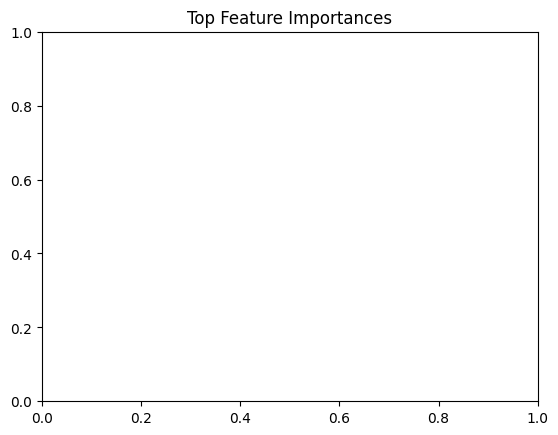

In [13]:
plt.title("Top Feature Importances")
